# Import Libraries

In [46]:
import json
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from wordcloud import WordCloud
import pickle
import re, string
import sys
import seaborn as sns
sns.set()
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import pickle

# Load the data

`data source`:http://jmcauley.ucsd.edu/data/amazon/

In [29]:
sport = []
for line in open('reviews_Sports_and_Outdoors_5.json', 'r'):
    sport.append(json.loads(line))

In [30]:
df=pd.DataFrame(sport)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014"
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012"
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012"
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,"02 5, 2012"
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013"


`where`

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review [2,3], e.g. 2/3 , 2 is numertaor , 3 denominator
  - Numertaor: Number of users who found the review helpful
  - Denominator: Number of users who indicated whether they found the review helpful or not
  - helpfulness of review is defined as the ratio of the number of consumers who found it helpful to the total number of consumers who had read and evaluated the review.
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [31]:
# createa a new column which combines review and summary 
df['combined_text'] = df['reviewText'] + ' ' + df['summary']

In [32]:
df.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,combined_text
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014",This came in on time and I am veru happy with ...
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012",I had a factory Glock tool that I was using fo...


# Data Cleaning

In [33]:
# to see if there are any missing values
df.isnull().sum()
# there are some reviewers' names are missing but it is find we can remove that columns,
#we can use reviewers ID 

reviewerID           0
asin                 0
reviewerName      1402
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
combined_text        0
dtype: int64

# EDA


In [34]:
# check how many unique values in rating column
df['overall'].value_counts()

5.0    188208
4.0     64809
3.0     24071
2.0     10204
1.0      9045
Name: overall, dtype: int64

In [35]:
# create a target column based on product_rating, if rating <=3 means bad:0 if rating >=4 good :1
df['target']=[0  if x<=3 else 1 for x in df['overall']]

In [36]:
# create a column for helpfulness Numerator and helpfulness Denominator
df['helpfulness_Numerator']  =[x[0] for x in df['helpful']]
df['helpfulness_Denominator']=[x[1] for x in df['helpful']]

In [37]:
# Double check the data 
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,combined_text,target,helpfulness_Numerator,helpfulness_Denominator
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014",This came in on time and I am veru happy with ...,1,0,0
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012",I had a factory Glock tool that I was using fo...,1,1,1
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012",If you don't have a 3/32 punch or would like t...,1,2,2


## Review Counts by Rating

In [42]:
rating

,index,overall
4,1.0,9045
3,2.0,10204
2,3.0,24071
1,4.0,64809
0,5.0,188208


Text(0.5, 1.0, 'Review Counts by Rating')

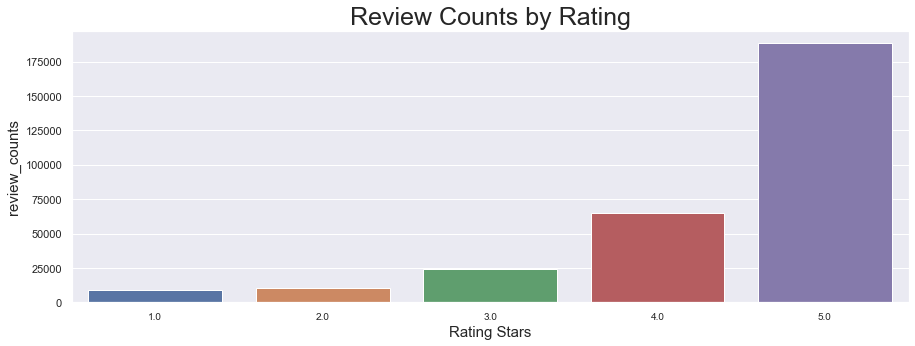

In [38]:
# plot review counts in different rating group
rating=pd.DataFrame(df['overall'].value_counts()).reset_index().sort_values(by='index',ascending=True)
plt.figure(figsize=(15,5))
sns.barplot(rating['index'],rating['overall'])
plt.xticks(fontsize=10)
plt.xlabel('Rating Stars',fontsize=15)
plt.ylabel('review_counts',fontsize=15)
plt.title('Review Counts by Rating',fontsize=25)
# for i in range(len(rating['index'])):
#     plt.text(i+0.9,list(rating['overall'])[::-1][i]+1000,'{}%'.format(round(rating['overall'][i]/sum(rating['overall'])*100,2)),fontsize=15)
# plt.show()

In [14]:
import pandas as pd
rating=pd.read_csv("rating.csv")
rating

,Unnamed: 0,index,overall
0,4,1.0,9045
1,3,2.0,10204
2,2,3.0,24071
3,1,4.0,64809
4,0,5.0,188208


Text(0.5, 1.0, 'Review Counts by Bad/Good Reviews')

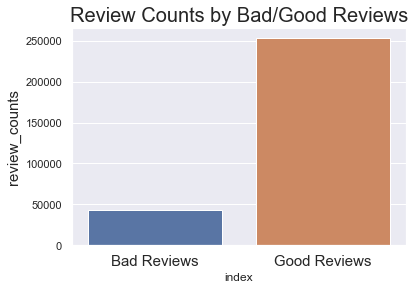

In [15]:
# plot review counts in bad review group and good review group
bad_good=pd.DataFrame(df['target'].value_counts()).reset_index().sort_values(by='index',ascending=False)

sns.barplot(bad_good['index'],bad_good['target'])
plt.xticks([0,1],["Bad Reviews","Good Reviews"],fontsize=15)
plt.ylabel('review_counts',fontsize=15)
plt.title('Review Counts by Bad/Good Reviews',fontsize=20)
# for i in range(len(bad_good['index'])):
#     plt.text(i-0.1,list(bad_good['target'])[i]+1000,'{}%'.format(round(bad_good['target'][i]/sum(bad_good['target'])*100,2)),fontsize=15)
# plt.show()

In [16]:
#bad_good.to_csv("bad_good.csv")
bad_good=pd.read_csv('bad_good.csv')
bad_good

,Unnamed: 0,index,target
0,0,1,253017
1,1,0,43320


## Helpfulness

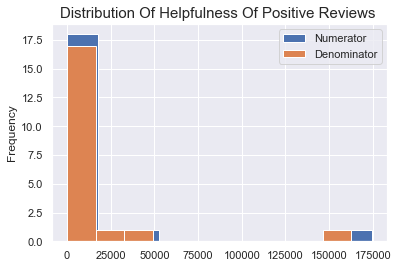

In [17]:
# distribution of helpfulness_Numerator and helpfulness_Denominator in positive reviews
plt.title('distribution of helpfulness of positive Reviews '.title(),fontsize=15)
df[df['target']==1]['helpfulness_Numerator'].value_counts()[:20].plot(kind='hist',label='Numerator')
df[df['target']==1]['helpfulness_Denominator'].value_counts()[:20].plot(kind='hist',label='Denominator')
plt.legend()
plt.show()

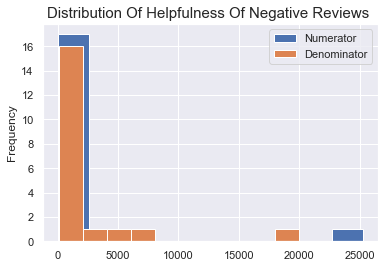

In [18]:
# distribution of helpfulness_Numerator and helpfulness_Denominator in negative reviews
plt.title('distribution of helpfulness of Negative Reviews '.title(),fontsize=15)
df[df['target']==0]['helpfulness_Numerator'].value_counts()[:20].plot(kind='hist',label='Numerator')
df[df['target']==0]['helpfulness_Denominator'].value_counts()[:20].plot(kind='hist',label='Denominator')
plt.legend()
plt.show()

In [19]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'combined_text',
       'target', 'helpfulness_Numerator', 'helpfulness_Denominator'],
      dtype='object')

## ReviewTime and target 

In [166]:
import datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

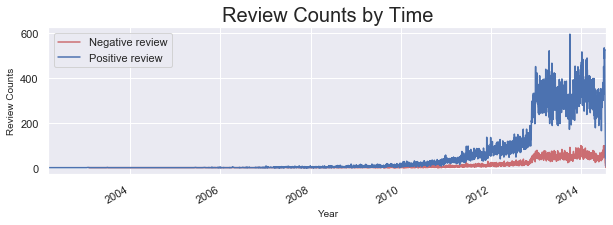

In [23]:

plt.figure(figsize=(10,3))
plt.title('Review Counts by Time',fontsize=20)
plt.ylabel('Review Counts',fontsize=10)
plt.xlabel('Year',fontsize=10)
df[df.target==0]['reviewTime'].value_counts().plot(label='Negative review',color='r',alpha=0.8)
df[df.target==1]['reviewTime'].value_counts().plot(label='Positive review',color='b')
plt.legend()
plt.show()
# In 2013 Amazon sells over 200 million products in the USA, 
#which are categorised into 35 departments and almost 20 million in Sports & Outdoors 

## Products

In [24]:
# let us see in different rating level which products have highest rating - best seller  
# plot the mean of rating for each product and got top 20 in rating :
pd.DataFrame(df.groupby('asin')['overall'].mean()).sort_values(by='overall',ascending=False).iloc[:5]
# 1st :Hydracentials Sporty 25 oz Insulated Stainless Steel Water
# 2nd:Table Tennis Racket Cover 
# 3rd : Drymax Run Mini Crew Socks
# 4th  :MSR Lightning Flotation Tail
# 5th Tiberius Arms First Strike Paintballs (White, 100 Count)


,overall
asin,
B00LFPS0CY,5.0
B003JJW610,5.0
B003EU8G22,5.0
B003EZQ53E,5.0
B003F4WKYW,5.0


In [25]:
# let us see which priducts are the best seller regardless their rating 
best_seller=pd.DataFrame(df['asin'].value_counts()).sort_values(by='asin',ascending=False).iloc[:5]
# 1st Bike
# 2nd Impact Sport OD Green Electric Earmuff  
# 3rd 50 Feet, Black : Rothco 550lb. Type III Nylon Paracord for yoga 
# 4th Survival Bundle - LifeStraw Personal Water Filter AND Magnesium Fire Starter 
# 5th HOPPE'S 24011 BoreSnake Rifle Bore Cleaner, M-16.22-.223 Caliber, 5.56mm


#[' Pistol Magazine Loader','Electric Earmuff','Nylon Paracord for yoga','LifeStraw Water Filter','Rifle Bore Cleaner'])



In [26]:
best_seller

,asin
B001HBHNHE,1042
B001T7QJ9O,763
B000S5ODN2,647
B0010O748Q,513
B0000C50K3,427


In [27]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'combined_text',
       'target', 'helpfulness_Numerator', 'helpfulness_Denominator'],
      dtype='object')

## Bigrams before removing stop words

In [28]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a


In [78]:
common_words_good = get_top_n_bigram(df[df['target']==1]['combined_text'], 30)
common_words_bad= get_top_n_bigram(df[df['target']==0]['combined_text'], 30)

In [31]:
# pd.DataFrame(common_words_good).to_csv("common_words_good.csv")
# pd.DataFrame(common_words_bad).to_csv("common_words_bad.csv")

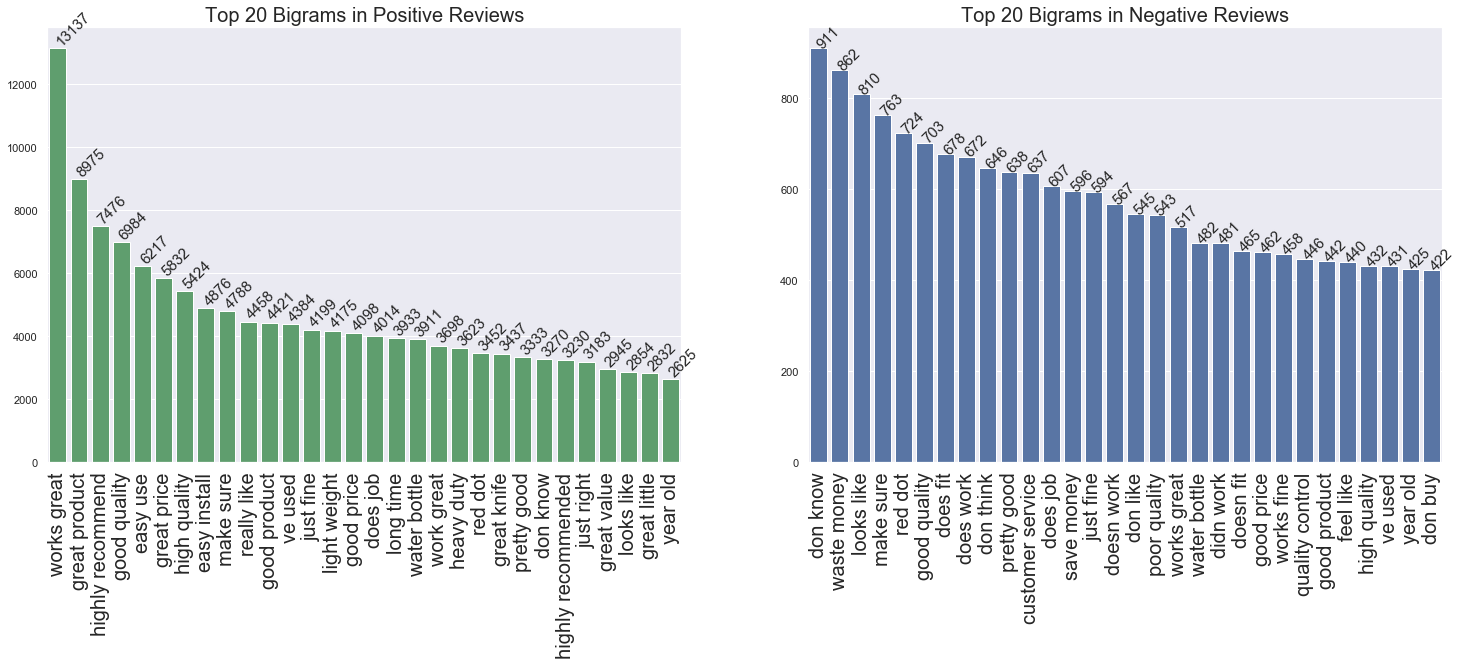

In [459]:
plt.figure(figsize=(25,8))
# good reviews bigrams
plt.subplot(1,2,1)
x_good=[x[0] for x in common_words_good]
y_good=[x[1] for x in common_words_good]
sns.barplot(x_good,y_good,color='g')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Bigrams in Positive Reviews",fontsize=20)
for i in range(len(x_good)):
    plt.text(i-0.2,y_good[i]+100,'{}'.format(y_good[i]),size=15,rotation=45)
    
plt.subplot(1,2,2)
x_bad=[x[0] for x in common_words_bad]
y_bad=[x[1] for x in common_words_bad]
sns.barplot(x_bad,y_bad,color='b')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Bigrams in Negative Reviews",fontsize=20)
for i in range(len(x_bad)):
    plt.text(i-0.2,y_bad[i],'{}'.format(y_bad[i]),size=15,rotation=45)


## Trigrams before removing stop words

In [33]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [34]:
common_words_good1 = get_top_n_trigram(df[df['target']==1]['combined_text'], 20)
common_words_bad1= get_top_n_trigram(df[df['target']==0]['combined_text'], 20)

In [35]:
pd.DataFrame(common_words_good1).to_csv("common_words_good1.csv")
pd.DataFrame(common_words_bad1).to_csv("common_words_bad1.csv")

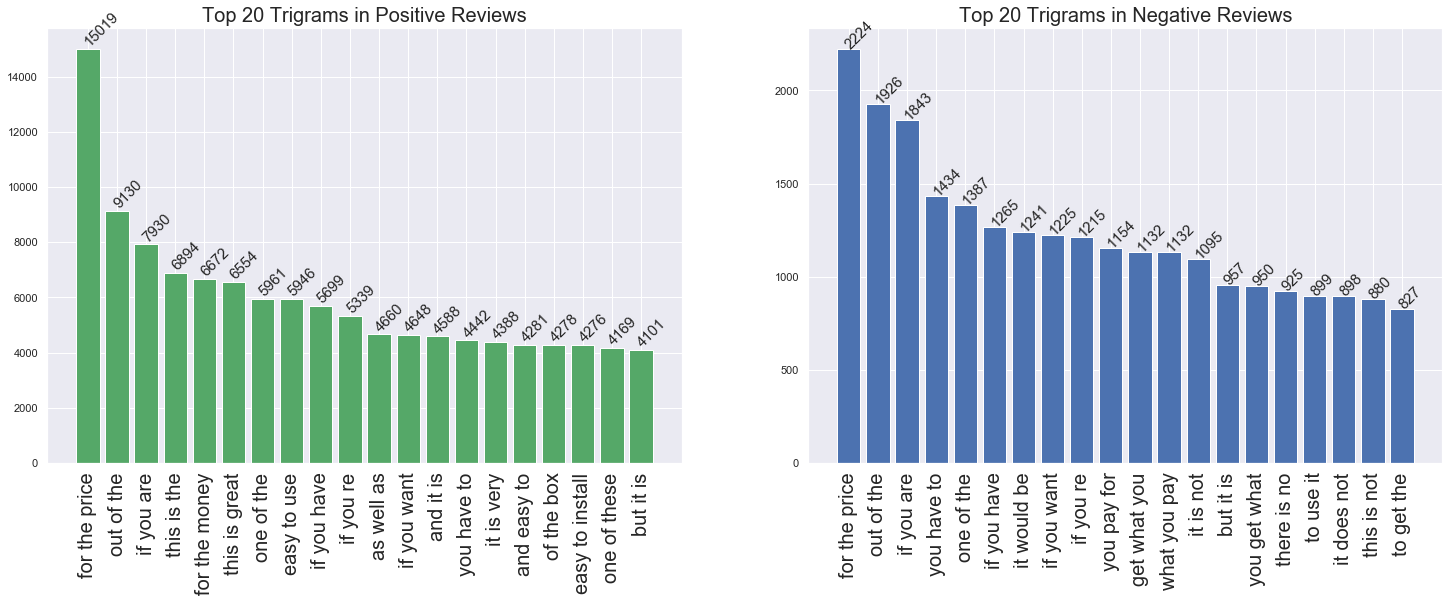

In [36]:
plt.figure(figsize=(25,8))
# good reviews bigrams
plt.subplot(1,2,1)
x_good1=[x[0] for x in common_words_good1]
y_good1=[x[1] for x in common_words_good1]
plt.bar(x_good1,y_good1,color='g')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Trigrams in Positive Reviews",fontsize=20)
for i in range(len(x_good1)):
    plt.text(i-0.2,y_good1[i]+100,'{}'.format(y_good1[i]),size=15,rotation=45)
    
plt.subplot(1,2,2)
x_bad1=[x[0] for x in common_words_bad1]
y_bad1=[x[1] for x in common_words_bad1]
plt.bar(x_bad1,y_bad1,color='b')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Trigrams in Negative Reviews",fontsize=20)
for i in range(len(x_bad1)):
    plt.text(i-0.2,y_bad1[i],'{}'.format(y_bad1[i]),size=15,rotation=45)


# Data Preprocessing and more EDA

In [50]:

def process_review(review):
    tokens = nltk.word_tokenize(review)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed
# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
# create a function stemming() and loop through each word in a review
def stemming(review):
    stemmed_review=[]
    for w in review:
        stemmed_review.append(ps.stem(w))
    return stemmed_review
# import libraries
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


# create a function  and loop through each word in  a review
def lemmatization(review):
    lemma_list=[]
    for word in review:
        lemma_word=lemmatizer.lemmatize(word) 
        lemma_list.append(lemma_word)
    return lemma_list

# create a funtion to remove stop words for a review
stop_words=set(stopwords.words("english"))
def remove_stop_words(review):
    filtered_review=[]
    for w in review:
        if w.lower() not in stop_words:
            filtered_review.append(w.lower())# convert all words into lowercase 
    return filtered_review
 

In [52]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
'said',"'s", "also",'one',"n't",'com', 'satirewire', '-', '–', 
'—', '_','satirewire.com',"/"]
sw_set = set(sw_list)
processed_review = list(map(process_review,df['combined_text']))

In [54]:
# Conbime all functions above and obtian cleaned text data 
def data_preprocessing(review):
    # loop through all reviews in lemma_reviews data
    stemming_reviews=[]
    for review in processed_review:
        stem_review=stemming(review)
        stemming_reviews.append(stem_review)
    # loop through all data 
    lemma_reviews=[]
    for review in stemming_reviews:
        lemma_review=lemmatization(review)
        lemma_reviews.append(lemma_review)
        #stop words removal
    no_stopwords_reviews=[]   
    for review in lemma_reviews:
        filtered_review=remove_stop_words(review)
        no_stopwords_reviews.append(filtered_review)
    return no_stopwords_reviews

In [55]:
cleaned_text_data=data_preprocessing(df['combined_text'])

In [56]:
pickle_out=open('cleaned_text_data', 'wb')
pickle.dump(cleaned_text_data, pickle_out)
pickle_out.close()

In [57]:
pickle_in_data = open("cleaned_text_data","rb")
cleaned_text_data = pickle.load(pickle_in_data)

## Frequency Distributions

In [58]:
# create two  new columns one for filtered_review , one for review length
df['filtered_review']=cleaned_text_data
df['review_len']=[len(x) for x in df['filtered_review']]

In [59]:
# obtian the bad reviews and good reviews data and w
badreviews =df[df.overall<=3.0]['filtered_review']
goodreviews = df[df.overall>=4.0]['filtered_review']

In [60]:
from itertools import chain
#pd.DataFrame(pd.Series(chain(*goodreviews)).value_counts())
bad_re=pd.DataFrame(pd.Series(chain(*badreviews)).value_counts()).sort_values(by=0,ascending=False).reset_index()
good_re=pd.DataFrame(pd.Series(chain(*goodreviews)).value_counts()).sort_values(by=0,ascending=False).reset_index()

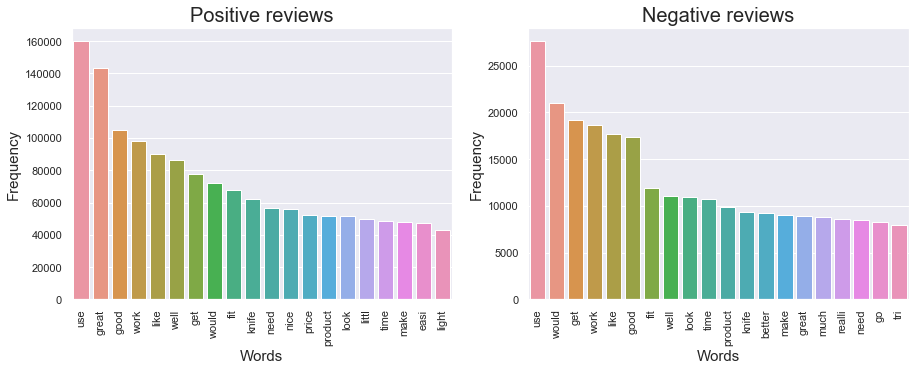

In [61]:
# Most common words in good reviews and bad reviews
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(good_re['index'][:20],good_re[0][:20])
plt.xticks(rotation=90)
plt.title('Positive reviews',fontsize=20)
plt.xlabel('Words',fontsize=15)
plt.ylabel('Frequency',fontsize=15)

plt.subplot(1,2,2)
sns.barplot(bad_re['index'][:20],bad_re[0][:20])
plt.xticks(rotation=90)
plt.title('Negative reviews',fontsize=20)
plt.xlabel('Words',fontsize=15)
plt.ylabel('Frequency',fontsize=15)


plt.show()


## Review Length and Rating 

In [62]:
df.groupby('target')['review_len'].mean().to_csv('length_rating.csv')

/Users/yingyuxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


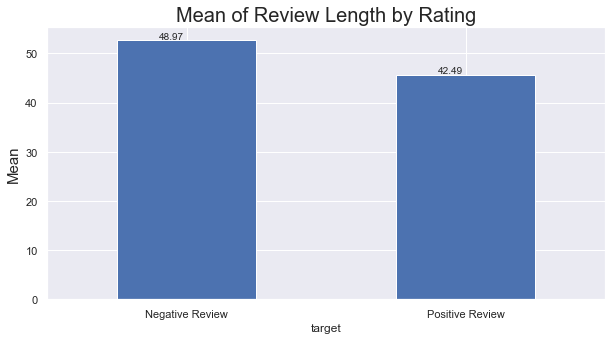

In [69]:
df.groupby('target')['review_len'].mean().plot(kind='bar',color='b')
plt.ylabel('Mean',fontsize=15)
plt.xticks([0,1],['Negative Review','Positive Review'],rotation=0)
plt.title('Mean of Review Length by Rating',fontsize=20)
plt.text(0-0.1,53,'48.97')
plt.text(1-0.1,46,'42.49')
plt.show()
# it makes sense the mean length of negative review is longer than positive reviews
# 1, if people are not satisfied with the product they will speak a lot with their compaint
#2, people they satisfied or feel okey with the prduct they might not writing any reviews and the rating
# will automatically become positive score or 
# will just say something " good and well or I love it and like it"


Mean of review length for nagative reviews and positive reviews are similary which is around 45.

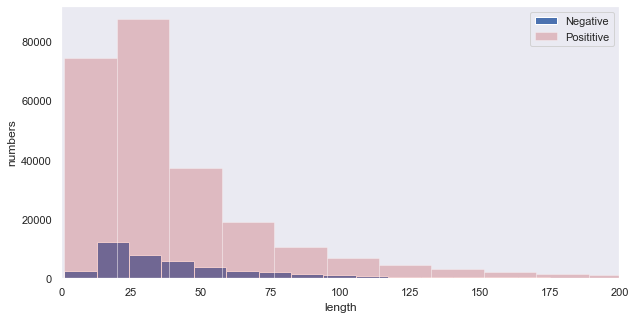

In [70]:
#overall 
plt.rcParams['figure.figsize'] = (10, 5)
bins = 150
plt.hist(df[df['target'] == 0]['review_len'], alpha = 1,color='b' ,bins=bins, label='Negative')
plt.hist(df[df['target'] == 1]['review_len'], alpha = 0.3, color='r',bins=bins, label='Posititive')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,200)
plt.grid()
plt.show()

## Word Clouds

In [9]:
common_words_good=pd.read_csv('common_words_good.csv')
common_words_bad=pd.read_csv('common_words_bad.csv')
common_words_good.columns

Index(['Unnamed: 0', '0', '1'], dtype='object')

In [10]:
# create dictinary for good review and bad review 
good_re_dictionary={}
for i in range(len(common_words_good)):
    good_re_dictionary[common_words_good['0'][i]]=common_words_good['1'][i]
    
bad_re_dictionary={}
for i in range(len(common_words_bad)):
    bad_re_dictionary[common_words_bad['0'][i]]=common_words_bad['1'][i]

In [12]:
# wordcloud function
from wordcloud import WordCloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

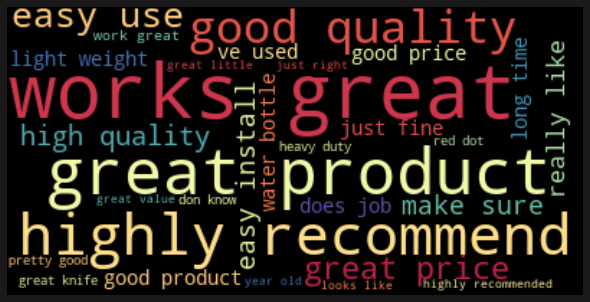

In [21]:
# Create the word cloud of Positive Reviews
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(good_re_dictionary)
plt.figure(figsize=(8,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

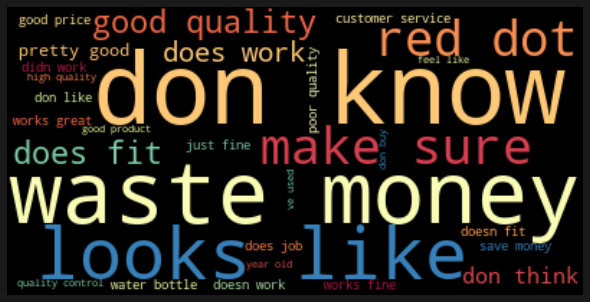

In [84]:
# Create the word cloud of Negative reviews
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(bad_re_dictionary)
plt.figure(figsize=(8,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Helpfulness and reviewtext

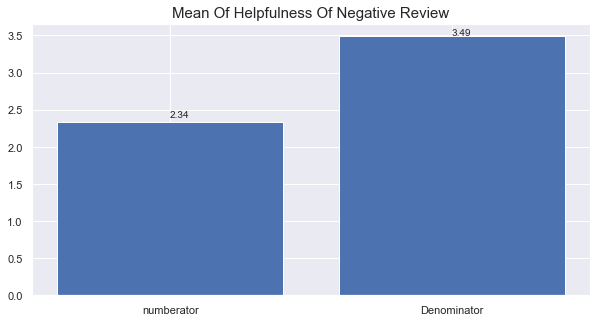

In [85]:
numer_0= df[df['target']==0]['helpfulness_Numerator'].mean()
deno_0=df[df['target']==0]['helpfulness_Denominator'].mean()
plt.bar(['numberator','Denominator'],[numer_0,deno_0])
plt.text(0,2.4,round(numer_0,2))
plt.text(1,3.5,round(deno_0,2))
plt.title('Mean of helpfulness of Negative review'.title(),fontsize=15)
plt.show()

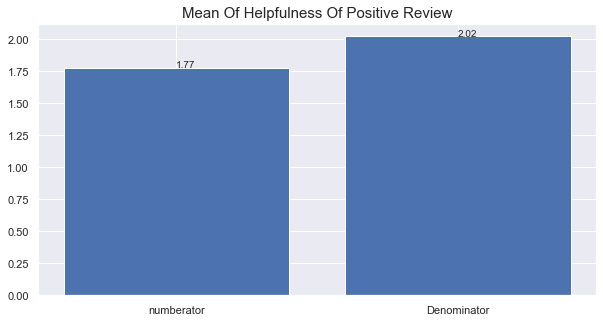

In [86]:
numer_1= df[df['target']==1]['helpfulness_Numerator'].mean()
deno_1=df[df['target']==1]['helpfulness_Denominator'].mean()
plt.bar(['numberator','Denominator'],[numer_1,deno_1])
plt.text(0,1.78,round(numer_1,2))
plt.text(1,2.02,round(deno_1,2))
plt.title('Mean of helpfulness of Positive review'.title(),fontsize=15)
plt.show()

In [87]:
# pickle_out=open('df', 'wb')
# pickle.dump(df, pickle_out)
# pickle_out.close()

In [44]:
pickle_in_data = open("df","rb")
df = pickle.load(pickle_in_data)

In [45]:
df.to_csv('df.csv')

# Train Test Split

In [90]:
#declare inputs and target
inputs=df[['filtered_review','unixReviewTime','helpfulness_Numerator', 'helpfulness_Denominator','review_len']]
target=df['target']

In [91]:
#train test split dataset 
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=.2, random_state=0)

In [92]:
# join all strings together for each row 
review_train=pd.DataFrame(data=[' '.join(x) for x in x_train['filtered_review']])
review_test=pd.DataFrame(data=[' '.join(x) for x in x_test['filtered_review']])

# Resampling 

In [93]:
from sklearn.utils import resample

In [94]:
# concatenate our training data back together
training  = pd.DataFrame()
training[list(x_train.columns)]=x_train
training['target']=y_train
training.head()

,filtered_review,unixReviewTime,helpfulness_Numerator,helpfulness_Denominator,review_len,target
275333,"[light, held, glock, round, protrud, past, bar...",1403913600,0,0,44,1
258272,"[repons, effect, time, excel, product, qualiti...",1350000000,1,2,14,1
124048,"[wish, youtub, video, advertis, knife, underr,...",1375401600,1,1,39,1
107684,"[say, amaz, product, wet, put, around, neck, s...",1312675200,2,2,33,1
255706,"[let, start, write, great, target, knock, disp...",1365206400,0,0,43,1


In [95]:
# separate minority and majority classes
negative_review= training[training.target==0]
positive_review= training[training.target==1]


In [96]:
# Get a class count to understand the class imbalance.
print('negative review count: '+ str(len(negative_review)))
print('positive review count: '+ str(len(positive_review)))

negative review count: 34606
positive review count: 202463


In [97]:
# upsample minority
negative_upsampled = resample(negative_review,
                          replace=True, # sample with replacement
                          n_samples=len(positive_review), # match number in majority class
                          random_state=23) # reproducible results
negative_upsampled.head()

,filtered_review,unixReviewTime,helpfulness_Numerator,helpfulness_Denominator,review_len,target
89050,"[expect, someth, nice, right, box, bitterli, d...",1378080000,1,1,35,0
37954,"[well, everi, sk, bit, differ, ga, piston, sli...",1287273600,5,7,48,0
85511,"[product, deliv, pretti, sure, could, possibl,...",1391558400,0,0,24,0
52064,"[grip, kind, univers, fit, specif, gun, best, ...",1365120000,0,0,18,0
36807,"[review, cheap, glass, remington, may, protect...",1364342400,4,12,72,0


In [98]:
# combine majority and upsampled minority
upsampled= pd.concat([positive_review, negative_upsampled])

# check new class counts
upsampled.target.value_counts()

1    202463
0    202463
Name: target, dtype: int64

In [99]:
y_train = upsampled.target
x_train = upsampled.drop('target', axis=1)

In [100]:
x_train.head()

,filtered_review,unixReviewTime,helpfulness_Numerator,helpfulness_Denominator,review_len
275333,"[light, held, glock, round, protrud, past, bar...",1403913600,0,0,44
258272,"[repons, effect, time, excel, product, qualiti...",1350000000,1,2,14
124048,"[wish, youtub, video, advertis, knife, underr,...",1375401600,1,1,39
107684,"[say, amaz, product, wet, put, around, neck, s...",1312675200,2,2,33
255706,"[let, start, write, great, target, knock, disp...",1365206400,0,0,43


Neural Network is slightly better than other models. Neural Network will be the final model for non_text data.

# Generating the Base First-Level Models

model stacking methond source: 
- https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html
- https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
- https://medium.com/@dan.j.izquierdo/an-ensemble-of-sklearners-quick-intro-to-model-stacking-e1a6a37600b0

## Vectorizing with TF-IDF for text data

In [101]:
# only select filtered_review as our dependent variable
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform([" ".join(x) for x in x_train['filtered_review']])
X_test = tfidf.transform([" ".join(x) for x in x_test['filtered_review']])

In [102]:
X_train,X_test

(<404926x68859 sparse matrix of type '<class 'numpy.float64'>'
 	with 14495746 stored elements in Compressed Sparse Row format>,
 <59268x68859 sparse matrix of type '<class 'numpy.float64'>'
 	with 2037670 stored elements in Compressed Sparse Row format>)

In [103]:
non_zero_cols = X_train.nnz / float(X_train .shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(X_test.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 35.79850639376084
Percentage of columns containing ZERO: 0.9994801187006236


## Modeling

- Naive Bayes Classifier
- Neural NetWork
- Logistic Regression

### Naive Bayes Classifier

In [104]:
# Grid Search 

In [105]:
from sklearn.model_selection import GridSearchCV
grid_params = {'alpha':[0.1,0.2,0.3,0.4,0.5],
                 'fit_prior': [True, False],  }

gs = GridSearchCV( MultinomialNB(), grid_params,scoring='f1')
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [106]:
print("Best Score: ", gs.best_score_)
print("Best Params: ", gs.best_params_)

Best Score:  0.8277981589745771
Best Params:  {'alpha': 0.1, 'fit_prior': True}


In [107]:
# fit the training dataset on the NB classifier
Naive = MultinomialNB(alpha=0.1, fit_prior= True)
Naive.fit(X_train,y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [108]:
#prediction
nb_train_pre=Naive.predict(X_train)
nb_test_pre=Naive.predict(X_test)

In [109]:
# Use accuracy_score function to get the accuracy
print("Naive Bayes Train Accuracy Score :",accuracy_score(nb_train_pre, y_train))
print("Naive Bayes Test Accuracy Score :",accuracy_score(nb_test_pre, y_test))

Naive Bayes Train Accuracy Score : 0.8479154215832029
Naive Bayes Test Accuracy Score : 0.8059155024633866


In [110]:
# calculate f1 scores for test data and train data 
nb_f1_score_test=f1_score(y_test,nb_test_pre)
nb_f1_score_train=f1_score(y_train,nb_train_pre)

print("Train data f1 score:{}".format(nb_f1_score_train))
print("Test data f1 score:{}".format(nb_f1_score_test ))

Train data f1 score:0.8475468316388042
Test data f1 score:0.8779587289798949


In [111]:
# calculate RMSE 
nb_rmse=np.sqrt(mean_squared_error(y_test,nb_test_pre))
print("RMSE of Neural Network Model:{}".format(nb_rmse))

RMSE of Neural Network Model:0.44055022135576477


### Neural NetWork

In [112]:
# thanks to :https://realpython.com/python-keras-text-classification/
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
import tensorflow as tf


Using TensorFlow backend.


In [113]:
#Before we build our model, we need to know the input dimension of our feature vectors.
input_dim = X_train.shape[1] 
input_dim

68859

In [114]:
# Add layers one by one in order 
model = Sequential()
model.add(keras.layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

#specify the optimizer and the loss function.
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

#Give an overview of the model and the number of parameters available for training:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                688600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 688,611
Trainable params: 688,611
Non-trainable params: 0
_________________________________________________________________


- specify the number of iterations I want the model to be training: epochs=50
- 70  samples I want to use in one epoch: batch_size=70

In [115]:
# # fit the model
history = model.fit(X_train, y_train,epochs=50, verbose=1,
                    validation_data=(X_test, y_test),batch_size=70)

Train on 404926 samples, validate on 59268 samples
Epoch 1/50
404926/404926 [==============================] - 487s 1ms/step - loss: 0.3733 - accuracy: 0.8414 - val_loss: 0.3602 - val_accuracy: 0.8416
Epoch 2/50
404926/404926 [==============================] - 376s 929us/step - loss: 0.2998 - accuracy: 0.8728 - val_loss: 0.3441 - val_accuracy: 0.8500
Epoch 3/50
404926/404926 [==============================] - 389s 961us/step - loss: 0.2622 - accuracy: 0.8893 - val_loss: 0.3608 - val_accuracy: 0.8485
Epoch 4/50
404926/404926 [==============================] - 424s 1ms/step - loss: 0.2310 - accuracy: 0.9055 - val_loss: 0.3755 - val_accuracy: 0.8550
Epoch 5/50
404926/404926 [==============================] - 352s 870us/step - loss: 0.2005 - accuracy: 0.9212 - val_loss: 0.4119 - val_accuracy: 0.8488
Epoch 6/50
   210/404926 [..............................] - ETA: 16:30 - loss: 0.1981 - accuracy: 0.9095

/Users/yingyuxuan/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


404880/404926 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9365

KeyboardInterrupt: 

In [42]:
# obtian Accuracies for train data and test data
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9986
Testing Accuracy:  0.8535


In [45]:
#prediction
nn_train_pre=model.predict_classes(X_train)
nn_test_pre=model.predict_classes(X_test)

# calculate f1 scores for test data and train data 
nn_f1_score_test=f1_score(y_test,nn_test_pre)
nn_f1_score_train=f1_score(y_train,nn_train_pre)

print("Train data f1 score:{}".format(nn_f1_score_train))
print("Test data f1 score:{}".format(nn_f1_score_test ))

Train data f1 score:0.9985557209771635
Test data f1 score:0.9146820718384028


In [751]:

print(confusion_matrix(y_test, nn_test_pre))

[[ 4034  4680]
 [ 4004 46550]]


In [46]:
# calculate RMSE 
nn_rmse=np.sqrt(mean_squared_error(y_test,nn_test_pre))
print("RMSE of Neural Network Model:{}".format(nn_rmse))

RMSE of Neural Network Model:0.38278046994196957


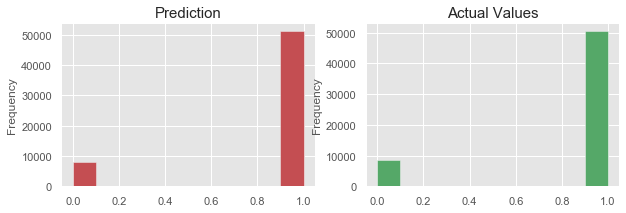

In [47]:
# figure size 
plt.figure(figsize=(10,3))
# subplot for prediction
plt.subplot(1,2,1)
pd.Series([x[0] for x in nn_test_pre]).plot(kind='hist',color='r')
plt.title('Prediction',fontsize=15)
# subplot for actual values 
plt.subplot(1,2,2)
y_test.plot(kind='hist',color='g')
plt.title('Actual Values',fontsize=15)

plt.show()

### Logistic regression

In [48]:
#import Logistic Regression
from sklearn.linear_model import LogisticRegression
# fit the model 
log_re = LogisticRegression(max_iter=1000)
log_re.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
#calculate scores for test data and train data 
test_data_score = log_re.score(X_test, y_test)
train_data_score = log_re.score(X_train, y_train)
print("Train data score:{}".format(train_data_score ))
print("Test data score:{}".format(test_data_score ))

Train data score:0.8629947200229178
Test data score:0.8395424174934197


In [50]:
# predict values for test data and train data
log_y_test_pre=log_re.predict(X_test)
log_y_train_pre=log_re.predict(X_train)

In [51]:
# calculate f1 scores for test data and train data 
log_f1_score_test=f1_score(y_test,log_y_test_pre)
log_f1_score_train=f1_score(y_train,log_y_train_pre)

print("Train data f1 score:{}".format(log_f1_score_train))
print("Test data f1 score:{}".format(log_f1_score_test ))

Train data f1 score:0.8622500540054675
Test data f1 score:0.9000210260723296


In [52]:
# calculate RMSE 
lr_rmse=np.sqrt(mean_squared_error(y_test,log_y_test_pre))
print("RMSE of Logistic Regression Model:{}".format(lr_rmse))

RMSE of Logistic Regression Model:0.40057156976822544


## XGBoost


In [140]:
# import xgboost as xgb

# gbm = xgb.XGBClassifier(
# learning_rate = 0.02,
#  n_estimators= 2000,
#  max_depth= 4,
#  min_child_weight= 2,
#  gamma=0.9,                        
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread= -1,
#  scale_pos_weight=1).fit(X_train, y_train)

In [141]:
# xgb_pre = gbm.predict(X_test)
# xgb_f1_score=f1_score(y_train,xgb_pre)

## Model Evaluation

In [53]:
## RMSE
list_rmse=pd.DataFrame()
list_rmse['model']=["Naive_Bayes",'Neural_NetWork',"Logistic Regression"]
list_rmse['RMSE']=[nb_rmse,nn_rmse,lr_rmse]
list_rmse['f1_Score']=[nb_f1_score_test,nn_f1_score_test,log_f1_score_test]
list_rmse
# Neural Network 's rmse is the smallest one.
# Neural Network is the final model for text data classification part.

,model,RMSE,f1_Score
0,Naive_Bayes,0.440550,0.877959
1,Neural_NetWork,0.382780,0.914682
2,Logistic Regression,0.400572,0.900021


# Frist-Level Predictions for non_text data

##  Standardization for Numerical data 

In [116]:
#import library for data standardization
from sklearn.preprocessing import StandardScaler

x_train_numer=x_train[['unixReviewTime', 'helpfulness_Numerator','helpfulness_Denominator', 'review_len']]
x_test_numer=x_test[['unixReviewTime', 'helpfulness_Numerator','helpfulness_Denominator', 'review_len']]

scaler = StandardScaler()  
scaler.fit(x_train_numer)

X_train_numer = scaler.transform(x_train_numer)  
X_test_numer = scaler.transform(x_test_numer)  

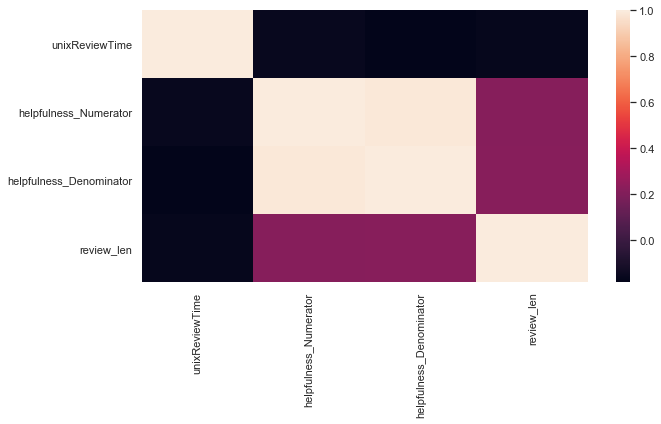

In [118]:
# correlation matrix
X_train_cor=pd.DataFrame(data=X_train_numer, columns=x_train_numer.columns)
sns.set(style="white")
sns.heatmap(X_train_cor.corr())

## Modeling for numerical data 
- Random Forest
- Logistic Regression
- Neural Network


### Random Forest 

In [119]:
from sklearn.model_selection import RandomizedSearchCV

In [120]:
# given prameters different values
random_grid={
             'n_estimators':list(range(400,500,10))
#              'max_depth':list(range(1,30,2)),
#               'max_features':list(range(1,5)),
#              'min_samples_leaf':list(range(1,23,2)),
#               'min_samples_split':list(range(2,21,2))                
             }
# random forest model
rf=RandomForestClassifier(n_jobs=-1,  random_state=0)

In [121]:
# randommized searchCV
RS=RandomizedSearchCV(rf,random_grid,cv=5,scoring="f1")

In [123]:
# fit the train data
RS.fit(X_train_numer,list(y_train)) 

In [ ]:
# obtian best parameters best score
RS.best_score_,RS.best_params_ # 0.9237666660184489

In [124]:
rfc=RandomForestClassifier(n_estimators=480,
                           max_depth=11, 
                           min_samples_leaf=11,
                           min_samples_split= 2,
                           n_jobs=-1,  random_state=0)

In [125]:
rfc.fit(X_train_numer,list(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=11, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=480,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [126]:
# Score for train and test data 
print("Score of train data :" ,rfc.score(X_train_numer,y_train))
print("Score of test data :" ,rfc.score(X_test_numer,y_test))

Score of train data : 0.6475479470322972
Score of test data : 0.7099615306742255


In [127]:
rf_num_train_pre=rfc.predict(X_train_numer)
rf_num_test_pre=rfc.predict(X_test_numer)
f1_score_numer_train=f1_score(list(y_train),rf_num_train_pre)
f1_score_numer_test=f1_score(list(y_test),rf_num_test_pre)

In [128]:
print("F1 Score of train data :" , f1_score_numer_train)
print("F1 Score of test data :" ,f1_score_numer_test)

F1 Score of train data : 0.6835044984908932
F1 Score of test data : 0.8156054234960953


In [129]:
def rmse(actual,predition):
    rmse=np.sqrt(mean_squared_error(actual,predition))
    return rmse

In [130]:
rfc_num_rmse=rmse(y_test,rf_num_test_pre)
rfc_num_rmse

0.5385521974013052

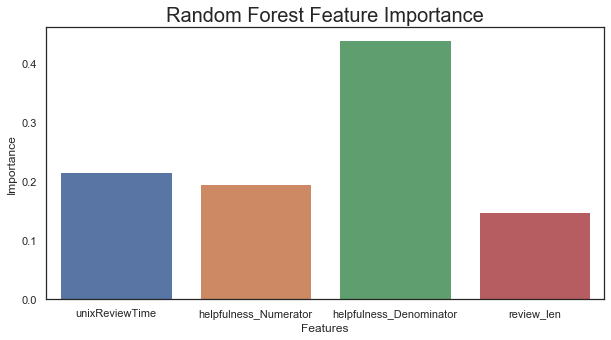

In [131]:
sns.barplot(x_train_numer.columns,rfc.feature_importances_)
plt.title('Random Forest Feature Importance',fontsize=20)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


### Logistic Regression

In [132]:
#import Logistic Regression
from sklearn.linear_model import LogisticRegression
log_regression = LogisticRegression()#max_iter=1000
log_regression.fit(X_train_numer, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [133]:
#calculate scores for test data and train data 
test_num_data_score = log_regression.score(X_test_numer, y_test)
train_num_data_score = log_regression.score(X_train_numer, y_train)
print("Train data score:{}".format(train_num_data_score ))
print("Test data score:{}".format(test_num_data_score ))

Train data score:0.6121661735724552
Test data score:0.7798812175204157


In [134]:
# predict values for test data and train data
logistic_num_test_pre=log_regression.predict(X_test_numer)
logistic_num_train_pre=log_regression.predict(X_train_numer)
# calculate f1 scores for test data and train data 
logistic_f1_score_num_test=f1_score(y_test,logistic_num_test_pre)
logistic_f1_score_num_train=f1_score(y_train,logistic_num_train_pre)

print("Train data f1 score:{}".format(logistic_f1_score_num_train))
print("Test data f1 score:{}".format(logistic_f1_score_num_test ))

Train data f1 score:0.6867352597374101
Test data f1 score:0.8680809755900256


In [135]:
lr_num_rmse=rmse(y_test,logistic_num_test_pre)
lr_num_rmse

0.46916818144412165

### Neural Network

In [136]:
#Before we build our model, we need to know the input dimension of our feature vectors.
input_num_dim = X_train_numer.shape[1] 
input_num_dim
# Add layers one by one in order 
model_num = Sequential()
model_num.add(keras.layers.Dense(10, input_dim=input_num_dim, activation='relu'))
model_num.add(keras.layers.Dense(1, activation='sigmoid'))

#specify the optimizer and the loss function.
model_num.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

#Give an overview of the model and the number of parameters available for training:
model_num.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [477]:
# fit the model
history_num = model_num.fit(X_train_numer, y_train,epochs=100, verbose=1,
                    validation_data=(X_test_numer, y_test),batch_size=50)

In [107]:
# obtian Accuracies for train data and test data
loss_num_train, accuracy_num_train = model_num.evaluate(X_train_numer, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_num_train))
loss_num_test, accuracy_num_test = model_num.evaluate(X_test_numer, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_num_test))

Training Accuracy: 0.6149
Testing Accuracy:  0.7537


In [109]:
#prediction
nn_num_train_pre=model_num.predict_classes(X_train_numer)
nn_num_test_pre=model_num.predict_classes(X_test_numer)
# calculate f1 scores for test data and train data 
nn_f1_score_num_test=f1_score(y_test,nn_num_test_pre)
nn_f1_score_num_train=f1_score(y_train,nn_num_train_pre)

print("Train data f1 score:{}".format(nn_f1_score_num_train))
print("Test data f1 score:{}".format(nn_f1_score_num_test ))

Train data f1 score:0.6784834244403158
Test data f1 score:0.8489388781391307


In [110]:
# calculate RMSE 
nn_num_rmse=rmse(y_test,nn_num_test_pre)
nn_num_rmse

0.49630816287423785

## Model evaluation

In [111]:
# this is the RMSE OF first level of model stacking
# since the logistic regression givs the best result with 
#the highest F1_Score:0.314816 and lowest RMSE :0.943810
# So logistic regression predicted values from X train was used as a new feature for 
# second level part of model stacking   
list_rmse

,model,RMSE,f1_Score
0,Naive_Bayes,0.440550,0.877959
1,Neural_NetWork,0.382780,0.914682
2,Logistic Regression,0.400572,0.900021


In [112]:
# At the second level, after used a new feature, all models performed well.
# rmse and f1_Score of each model has no big difference. 
# The Neural Network model gives the best
# result with RMSE:0.312314 and f1_score: 0.944547
ME=pd.DataFrame()
ME['Model']=['Random Forest','Logistic Regression','Neural Network']
ME['RMSE']=[rfc_num_rmse,lr_num_rmse,nn_num_rmse]
ME['f1_score']=[f1_score_numer_test,logistic_f1_score_num_test,nn_f1_score_num_test]
ME

,Model,RMSE,f1_score
0,Random Forest,0.538552,0.815605
1,Logistic Regression,0.469168,0.868081
2,Neural Network,0.496308,0.848939


# Second-Level Predictions from the First-level Output


## First-level output as new features


Having now obtained the first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [155]:
x_train2 = pd.DataFrame( {
    
     'Naive_Bayes_1': nb_train_pre.ravel(),
     'Neural_Network1': nn_train_pre.ravel(),
     'Logistic_Regression1': log_y_train_pre.ravel(),
     'Random_Forest2': rf_num_train_pre.ravel(),
     'Logistic_Regression2':logistic_num_train_pre.ravel(),
    'Neural_Network2':nn_num_train_pre.ravel()
                                        
    })

x_train2.head()

,Naive_Bayes_1,Neural_Network1,Logistic_Regression1,Random_Forest2,Logistic_Regression2,Neural_Network2
0,0,1,1,0,1,1
1,1,1,1,0,0,0
2,1,1,1,0,1,1
3,1,1,1,1,1,1
4,0,1,1,1,1,1


In [154]:
x_test2 = pd.DataFrame( {
    
     'Naive_Bayes_1': nb_test_pre.ravel(),
     'Neural_Network1': nn_test_pre.ravel(),
     'Logistic_Regression1': log_y_test_pre.ravel(),
     'Random_Forest2': rf_num_test_pre.ravel(),
     'Logistic_Regression2':logistic_num_test_pre.ravel(),
    'Neural_Network2':nn_num_test_pre.ravel()
                                        })

x_test2.head()

,Naive_Bayes_1,Neural_Network1,Logistic_Regression1,Random_Forest2,Logistic_Regression2,Neural_Network2
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,0,1,0,0,0,0
4,1,1,1,1,1,1


(404926, 404926)

In [267]:
# x_test2.to_csv("x_test.csv")
# x_train2.to_csv("x_train.csv")

In [274]:
# pd.DataFrame(y_train).to_csv("y_train.csv")
# pd.DataFrame(y_test).to_csv("y_test.csv")

In [ ]:
x_test2
x_train2
y_train
y_test=

## Correlation Heatmap of the Second Level Training set

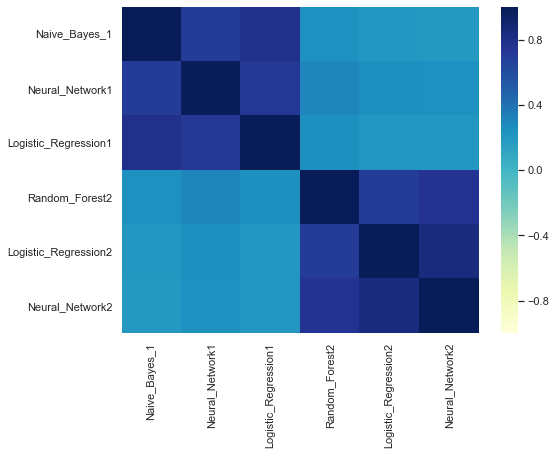

In [156]:
plt.figure(figsize=(8,6))
sns.heatmap(x_train2.corr(),vmin=-1,cmap='YlGnBu')

## Modeling

### XGboost

In [157]:
import xgboost as xgb

In [187]:
# given prameters different values
Random_Grid={
#              'n_estimators':list(range(50,500,50)),
               'max_depth':list(range(1,30,2)),
#               'max_features':list(range(1,5)),
#              'min_samples_leaf':list(range(1,23,2)),
#               'min_samples_split':list(range(2,21,2))                
             }
# random forest model
gbm = xgb.XGBClassifier(  max_depth= 27
                          n_estimators=400,
                         n_jobs=-1,  
                         random_state=0)

In [188]:
# randommized searchCV
rs=RandomizedSearchCV(gbm,Random_Grid,cv=5,scoring="f1")

In [189]:
# fit the train data
rs.fit(x_train2,list(y_train)) 

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=400,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='d

In [192]:
# obtian best parameters best score
rs.best_score_,rs.best_params_ 
# (0.9985557061142603, {'n_estimators': 400})
# (0.9985557061142603, {'n_estimators': 350})
#( 0.9985557061142603, {'n_estimators': 250})

(0.9985557061142603, {'max_depth': 27})

In [193]:
GBM = xgb.XGBClassifier(max_depth= 27,
                        n_estimators=400,
                        n_jobs=-1,  
                        random_state=0)


In [194]:
# fit the model 
GBM.fit(x_train2, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=27,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [195]:
train_pre=GBM.predict(x_train2)
test_pre=GBM.predict(x_test2)

In [196]:
f1_score_train=f1_score(list(y_train),train_pre)
f1_score_test=f1_score(list(y_test),test_pre)
# Score for train and test data 
print("F1 Score of train data :" , f1_score_train)
print("F1 Score of test data :" ,f1_score_test)

F1 Score of train data : 0.9985557209771635
F1 Score of test data : 0.9146820718384028


In [198]:
xgb_rmse=rmse(y_test,test_pre)
xgb_rmse

0.38278046994196957

### Neural Network 

In [227]:
#Before we build our model, we need to know the input dimension of our feature vectors.
input_dimen = x_train2.shape[1] 
input_dimen
# Add layers one by one in order 
model_stack = Sequential()
model_stack.add(keras.layers.Dense(10, input_dim=input_dimen, activation='relu'))
model_stack.add(keras.layers.Dense(1, activation='sigmoid'))

#specify the optimizer and the loss function.
model_stack.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

#Give an overview of the model and the number of parameters available for training:
model_stack.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [461]:
# fit the model
history_stack = model_stack.fit(x_train2, y_train,epochs=1000, verbose=False,
                    validation_data=(x_test2, y_test),batch_size=50)

In [237]:
# obtian Accuracies for train data and test data
loss, accuracy = model_stack.evaluate(x_train2, np.array(y_train) , verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9986


In [239]:
loss_num, accuracy = model_stack.evaluate(x_test2, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8535


In [241]:
#prediction
train_pre=model_stack.predict_classes(x_train2)
test_pre=model_stack.predict_classes(x_test2)
# calculate f1 scores for test data and train data 
f1_test=f1_score(y_test,test_pre)
f1_train=f1_score(y_train,train_pre)

print("Train data f1 score:{}".format(f1_train))
print("Test data f1 score:{}".format(f1_test ))

Train data f1 score:0.9985557209771635
Test data f1 score:0.9146820718384028


# Final Model evalueation

In [246]:
# calculate RMSE 
rmse(y_test,test_pre),xgb_rmse

# we can see the RMSE are same numbers 

(0.38278046994196957, 0.38278046994196957)

In [247]:
# Compaire xgboost and NN f1 score  and both of them are same also 
f1_test,f1_score_test

(0.9146820718384028, 0.9146820718384028)

In [244]:
# list_rmse is the result form  analysis for text data
list_rmse 
# compare with the stacking part results above 
#we can see Neural Network in text data analysis gave the same f1 score and rmse.
# that means NN model already dilivered the best result and reached the maximum.

,model,RMSE,f1_Score
0,Naive_Bayes,0.440550,0.877959
1,Neural_NetWork,0.382780,0.914682
2,Logistic Regression,0.400572,0.900021


In [245]:
# So we can see that other non-text varibales also can affect our target but 
# text data is the most powerful one.

,Model,RMSE,f1_score
0,Random Forest,0.538552,0.815605
1,Logistic Regression,0.469168,0.868081
2,Neural Network,0.496308,0.848939
